# 1.Importing libraries

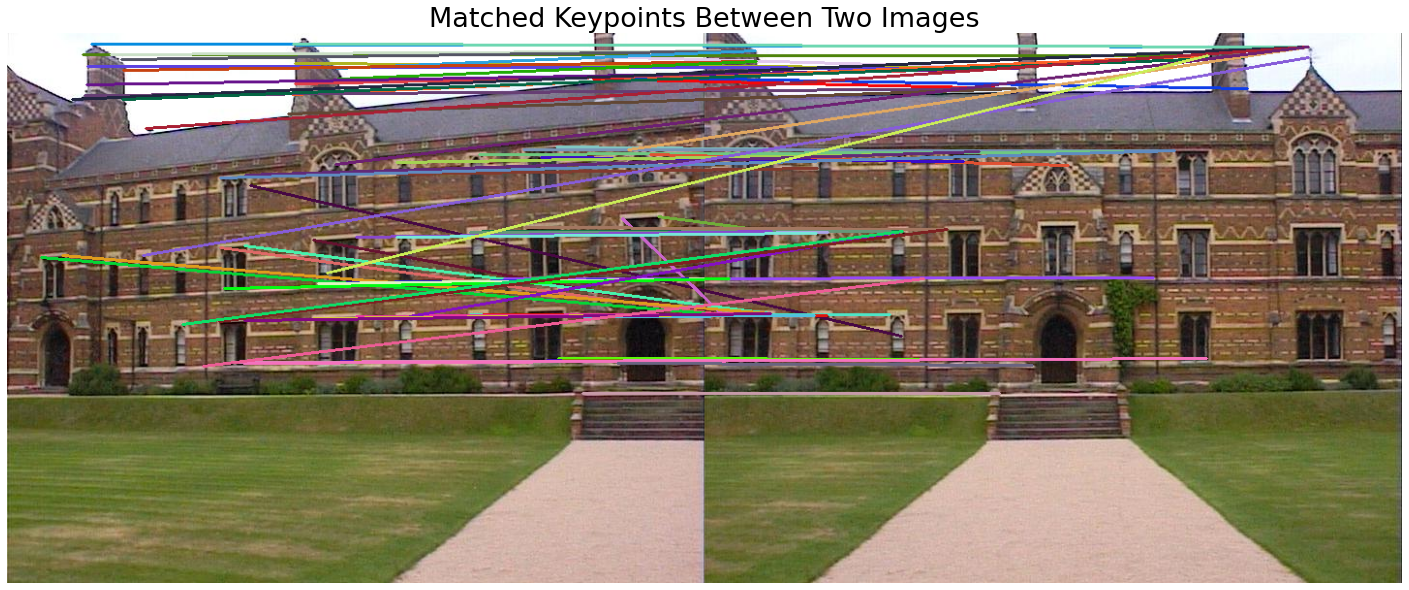

In [2]:
# Importing Libraries
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Function for enhance corner detection
def refine_corners(corners, img):
    corners = cv2.dilate(corners, None)
    max_value = corners.max()
    indices = np.where(corners > 0.04 * max_value)
    refined_points = np.zeros((img.shape[0], img.shape[1]))
    refined_points[indices] = 1
    return refined_points

# Function for locate and filter keypoints in the image
def detect_and_filter_keypoints(img):
    corners = cv2.cornerHarris(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 3, 3, 0.1)
    filtered_corners = refine_corners(corners, img)
    return filtered_corners

# Function for validate keypoints based on given parameters
def validate_keypoints(keypoints, height, width, descriptor_half_size, threshold, i, j):
    if keypoints[i, j]:
        if i + descriptor_half_size >= height or j + descriptor_half_size >= width or i - descriptor_half_size < 0 or j - descriptor_half_size < 0:
            keypoints[i, j] = 0
        else:
            keypoints[i - threshold:i + threshold + 1, j - threshold:j + threshold + 1] = 0
            keypoints[i, j] = 1
    return keypoints

# Function for double filtering of keypoints from two images
def apply_double_filtering(keypoints1, keypoints2, threshold, descriptor_size):
    height, width = keypoints1.shape
    descriptor_half_size = descriptor_size // 2
    threshold_half = threshold // 2
    
    for i in range(height):
        for j in range(width):
            keypoints1 = validate_keypoints(keypoints1, height, width, descriptor_half_size, threshold_half, i, j)
    
    height, width = keypoints2.shape
    for i in range(height):
        for j in range(width):
            keypoints2 = validate_keypoints(keypoints2, height, width, descriptor_half_size, threshold_half, i, j)
    
    return keypoints1, keypoints2

# Function to compare keypoints between two images
def match_keypoints(image1, keypoints1, image2, keypoints2, descriptor_size):
    half_size = descriptor_size // 2
    scores = []
    for keypoint in keypoints1:
        temp_score = -1
        best_match = 0
        for comparison_keypoint in keypoints2:
            window1 = image1[keypoint[0] - half_size:keypoint[0] + half_size + 1, keypoint[1] - half_size:keypoint[1] + half_size + 1, :]
            window2 = image2[comparison_keypoint[0] - half_size:comparison_keypoint[0] + half_size + 1, comparison_keypoint[1] - half_size:comparison_keypoint[1] + half_size + 1, :]
            score = cv2.matchTemplate(window1, window2, cv2.TM_CCORR_NORMED)
            if score > temp_score:
                temp_score = score
                best_match = comparison_keypoint
        scores.append(best_match)
    return scores

# Function to extract keypoint indices
def extract_indices(keypoints):
    indices = []
    for i in range(keypoints.shape[0]):
        for j in range(keypoints.shape[1]):
            if keypoints[i, j] == 1:
                indices.append((i, j))
    return indices

# Function for draw lines between matched keypoints
def connect_keypoints(srcs, dsts, img1, img2):
    width_img2 = img2.shape[1]
    for src, dst in zip(srcs, dsts):
        src_coords = (src[1], src[0])
        dst_coords = (dst[1] + width_img2, dst[0])
        cv2.line(img1, src_coords, dst_coords, (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)), 2)
    return img1

# Main function to find matching keypoints between two images
def find_matching_keypoints(img1, img2):
    ''' 
    Identifies matching keypoints between two images.
    
    Parameters:
        img1 (numpy.ndarray): First input image.
        img2 (numpy.ndarray): Second input image.
    
    Returns:
        numpy.ndarray: Image with matched keypoints drawn.
    '''
    
    output = None
    
    threshold = 20
    descriptor_size = 25
    keypoints1 = detect_and_filter_keypoints(img1)
    keypoints2 = detect_and_filter_keypoints(img2)

    keypoints1, keypoints2 = apply_double_filtering(keypoints1, keypoints2, threshold, descriptor_size)

    keypoints1_indices = extract_indices(keypoints1)
    keypoints2_indices = extract_indices(keypoints2)
    
    matched_results = match_keypoints(img1, keypoints1_indices, img2, keypoints2_indices, descriptor_size)
    combined_image = np.concatenate([img1, img2], axis=1)
    output = connect_keypoints(keypoints1_indices, matched_results, combined_image, img2)

    # Plot the output image 
    plt.figure(figsize=(25, 20))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title('Matched Keypoints Between Two Images', fontsize=27)
    plt.axis('off')
    plt.show()

# Apply functions to find matches between to input images in assingment 4
image1 = cv2.imread('image 3.jpg')
image2 = cv2.imread('image 4.jpg')
find_matching_keypoints(image1, image2)